# Colorization Autoencoder

In [1]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Dataset

In [2]:
def rbg2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [3]:
(x_train, _), (x_test, _) = cifar10.load_data()

In [4]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [8]:
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

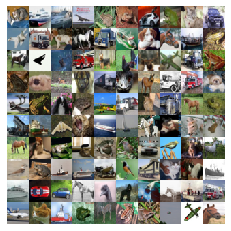

In [10]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.imshow(imgs, interpolation='none')
plt.show()

In [11]:
x_train_gray = rbg2gray(x_train)
x_test_gray = rbg2gray(x_test)

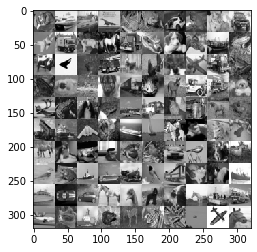

In [13]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

In [14]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [15]:
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [16]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

In [17]:
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

# Model

## Hyperparameter

In [18]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layer_filters = [64, 128, 256]

## Encoder

In [19]:
inputs = Input(shape = input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)

shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [20]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

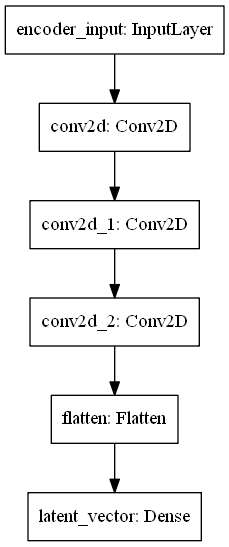

In [21]:
plot_model(encoder)

## Decoder

In [22]:
latent_inputs = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)

outputs = Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid',padding='same',name='decoder_output')(x)

In [24]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731

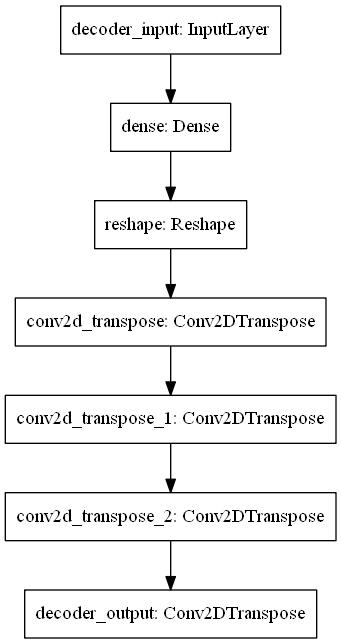

In [26]:
plot_model(decoder)

### Autoencoder

In [25]:
AE = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
AE.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 256)               1418496   
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [28]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

손실이 5epochs 내에 개선되지 않으면 학습속도를 sqrt(0.1)을 사용해 감소

In [29]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                              cooldown=0, patience=5, verbose=1, min_lr=0.5e-6)

In [30]:
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)

In [32]:
AE.compile(loss='mse', optimizer='adam')

In [33]:
callbacks = [lr_reducer, checkpoint]

In [34]:
AE.fit(x_train_gray, x_train, validation_data=(x_test_gray, x_test), epochs=30, batch_size=batch_size, callbacks=callbacks)

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0157
Epoch 00001: val_loss improved from inf to 0.01145, saving model to C:\Users\ilvna\Portfolio\DS\AE\saved_models\colorized_ae_model.001.h5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0157 - val_loss: 0.0114
Epoch 2/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0102
Epoch 00002: val_loss improved from 0.01145 to 0.00942, saving model to C:\Users\ilvna\Portfolio\DS\AE\saved_models\colorized_ae_model.002.h5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0102 - val_loss: 0.0094
Epoch 3/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0092
Epoch 00003: val_loss improved from 0.00942 to 0.00894, saving model to C:\Users\ilvna\Portfolio\DS\AE\saved_models\colorized_ae_model.003.h5
1563/1563 [==============================] - 15s 10ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 4/30
1561/1563 [============================>.] - ETA: 0

In [35]:
x_decoded = AE.predict(x_test_gray)

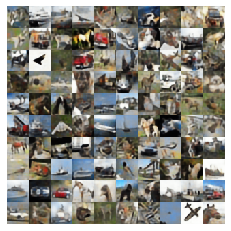

In [37]:
imgs_decoded = x_decoded[:100]
imgs_decoded = imgs_decoded.reshape((10, 10, img_rows, img_cols, channels))
imgs_decoded = np.vstack([np.hstack(i) for i in imgs_decoded])
plt.figure()
plt.axis('off')
plt.imshow(imgs_decoded, interpolation='none')
plt.show()

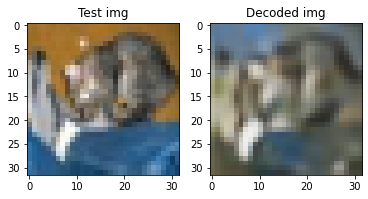

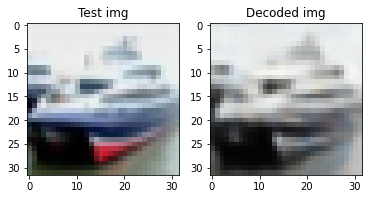

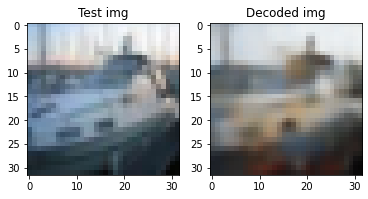

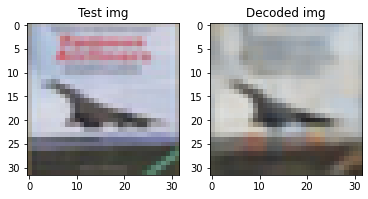

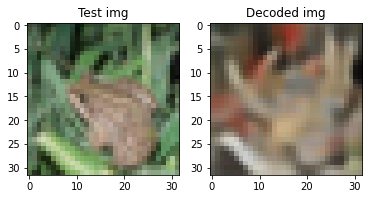

In [51]:
for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(x_test[i])
    plt.title('Test img')

    plt.subplot(1,2,2)
    plt.imshow(x_decoded[i])
    plt.title('Decoded img')
    
    plt.show()